In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

import seaborn as sns
import mapclassify as mc
import matplotlib.pyplot as plt


In [3]:
dataset = pd.read_pickle('../../geodata/results/02_spatial_lagged_master.pkl')
# dataset = pd.read_pickle('../../../geodata/results/02_spatial_lagged_master.pkl')

In [4]:
gdf_hexbn = gpd.read_file('../../geodata/ch_spatialbins/hexbin_viewdata.gpkg')#.dropna()


In [5]:
import mapclassify as mc
n = 30
max_slope = dataset['nabr_med_slope'].max()
max_count = dataset['nabr_count'].max()
bin_slope = mc.NaturalBreaks(gdf_hexbn.query('slope_median < @max_slope').slope_median.dropna(), k = n).bins.round().astype('int')
bin_count = mc.Quantiles(gdf_hexbn.query('count < @max_count')['count'].dropna(), k = n).bins.round().astype('int')


c:\Users\swietek\Miniconda3\envs\env_intel_sdb\lib\site-packages\mapclassify\classifiers.py:255: UserWarning: Not enough unique values in array to form 30 classes. Setting k to 28.
  warnings.warn(


In [6]:
dataset['slope_bin'] = pd.cut(dataset['nabr_med_slope'], bins=bin_slope)
dataset['bdensity_bin'] = pd.cut(dataset['nabr_count'], bins=bin_count)

r_bldg = dataset['bdensity_bin'].cat.categories.right.map(int).astype(str)
r_slope = dataset['slope_bin'].cat.categories.right.map(int).astype(str)+u'\N{DEGREE SIGN}'

dataset['slope_bin'] = dataset['slope_bin'].cat.rename_categories(dict(zip(dataset['slope_bin'].cat.categories,r_slope)))
dataset['bdensity_bin'] = dataset['bdensity_bin'].cat.rename_categories(dict(zip(dataset['bdensity_bin'].cat.categories,r_bldg)))

In [13]:
def plot_heat(x, cmap, title, ax , alpha, cbar_title ,  cbar = True):
    sns.heatmap(x, ax=ax,cmap = cmap, square = True, linewidths=0, alpha = alpha, cbar = cbar, cbar_kws={'label': cbar_title,'shrink': 0.5, 'orientation': 'vertical'})
    # ax.set_title('Average Net-Income')
    # ax.set_yticklabels(r_bldg,  rotation = 0)
    # ax.set_xticklabels(r_slope+u'\N{DEGREE SIGN}', rotation = 0)
    ax.set_axisbelow(True)
    # ax.xaxis.grid(color='gray', linestyle='dashed')
    # ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.set_title(title, ha = 'left', x= 0)
    ax.set_xlabel('Terrain Slope')
    ax.set_ylabel('Building Density')
    

In [8]:
dataset = dataset.assign(pred = dataset['XGB'].round(0))
dataset['mm_nabr_pred'] =(dataset.nabr_avg_pred - dataset.nabr_avg_pred.min() )/(dataset.nabr_avg_pred.max() - dataset.nabr_avg_pred.min() )


In [9]:
sns.set_theme()
# sns.set_style('white')
sns.set_context("paper", font_scale = 1)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rcParams['svg.fonttype'] = 'none'

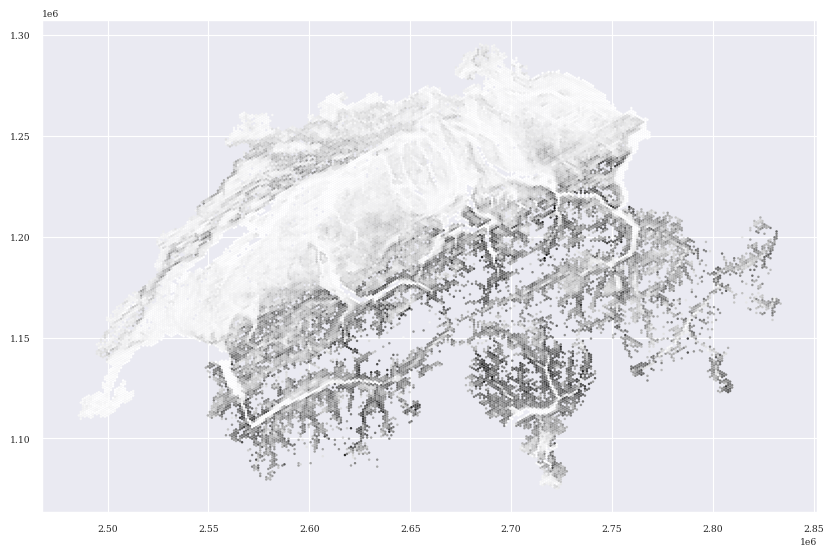

In [10]:
ax  = gdf_hexbn.plot('slope_median', cmap = 'Greys', legend = False, figsize = (10,10), edgecolor = 'none')
# dataset.sample(100000).plot('mm_nabr_pred', cmap = 'RdPu', scheme = 'naturalbreaks', ax = ax, markersize = .1)

In [11]:
grp = dataset.groupby(['slope_bin','bdensity_bin'])
X = pd.concat([
        grp['hexbin_id'].unique().rename('hexbin_id'),
        grp.size().rename('num_buildings'),
        grp['mm_nabr_pred'].mean().rename('meanVC'),
        grp['mm_nabr_pred'].skew().rename('skewVC'),
        grp['net_income_ptp'].mean().rename('meanCLI'),
        grp['net_income_ptp'].skew().rename('skewCLI'),
        grp['nabr_count'].mean().rename('nabr_count'),
        grp['nabr_med_slope'].mean().rename('nabr_med_slope'),
    ], axis = 1)

In [279]:
hx_id = X.query('num_buildings > 1000').query('nabr_count < 17').hexbin_id.explode().unique()
ax = gdf_hexbn.plot(color = 'Grey')
gdf_hexbn.query('hexbin_id in @hx_id').plot(color = 'Red', ax = ax)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


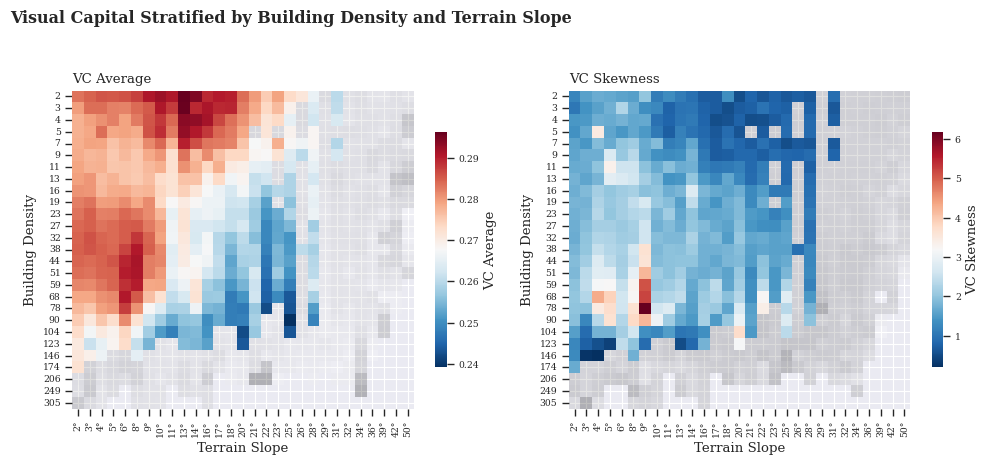

In [17]:
fig, (axes) = plt.subplots(1,2, figsize = (10,5), sharex=True, sharey=False)

Xcount = dataset.groupby(['slope_bin','bdensity_bin'])['mm_nabr_pred'].count().unstack()
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['mm_nabr_pred'].mean().unstack()
X_income = dataset.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].mean().unstack()

thr = 1000

plot_heat(X_vc[Xcount <= thr].T, 'Greys', '', axes[0], .25, '', False)
plot_heat(X_vc[Xcount > thr].T,'RdBu_r', 'VC Average', axes[0], 1, 'VC Average', True)
# plot_heat(X_vc.T,'RdBu_r', 'VC Skew', axes[0], 1,'VC Mean', True)

X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['mm_nabr_pred'].skew().unstack()
X_income = dataset.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].mean().unstack()

plot_heat(X_vc[Xcount <= thr].T,'Greys', '', axes[1], .25,'',False)
plot_heat(X_vc[Xcount > thr].T,'RdBu_r', 'VC Skewness', axes[1], 1,'VC Skewness', True)
# plot_heat(X_vc.T,'RdBu_r', 'VC Skew', axes[1], 1,'VC Skewness', True)

for ax in axes:
    ax.tick_params(axis = 'both', which = 'major', bottom=True, left = True)

plt.tight_layout()
plt.suptitle('Visual Capital Stratified by Building Density and Terrain Slope', x = 0, ha = 'left', fontweight = 'bold')
plt.savefig('../../figs/06_urban_nat_form.jpg', dpi = 300)

Text(0.5, 0.98, 'Urban and Natural Form')

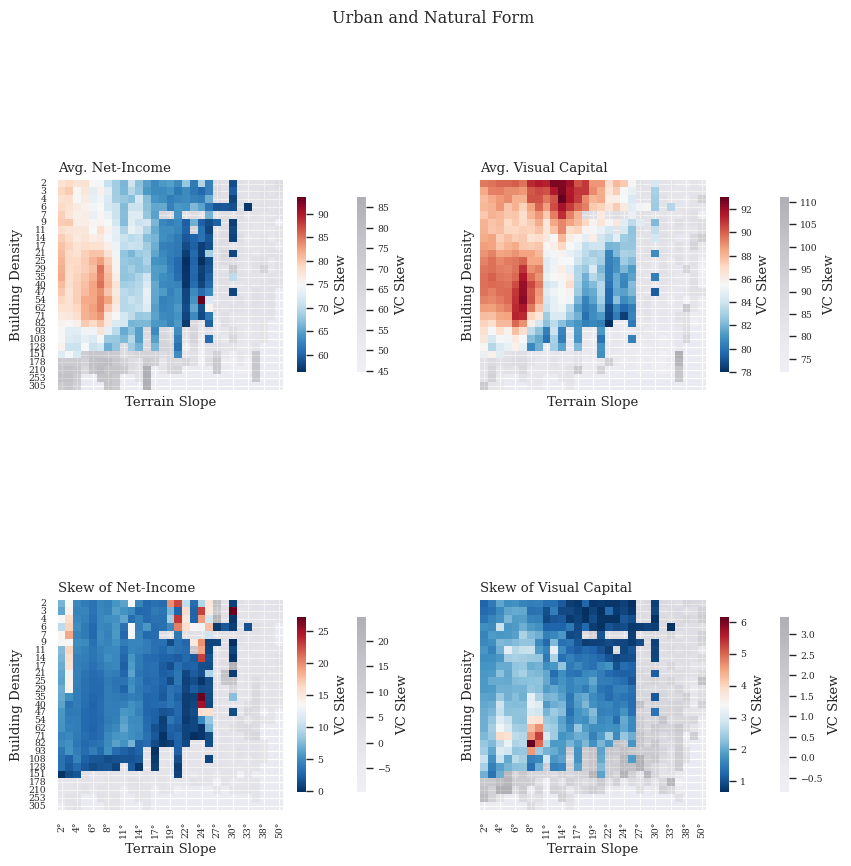

In [143]:
fig, (axes) = plt.subplots(2,2, figsize = (10,10), sharex=True, sharey=True)

Xcount = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].count().unstack()
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].mean().unstack()
X_income = dataset.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].mean().unstack()

thr = 1000

plot_heat(X_income[Xcount <= thr].T, 'Greys', '', axes[0,0], .25, False)
plot_heat(X_income[Xcount > thr].T,'RdBu_r', 'Avg. Net-Income', axes[0,0], 1)

plot_heat(X_vc[Xcount <= thr].T,'Greys', '', axes[0,1], .25, False)
plot_heat(X_vc[Xcount > thr].T,'RdBu_r', 'Avg. Visual Capital', axes[0,1], 1)

X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].skew().unstack()
X_income = dataset.groupby(['slope_bin','bdensity_bin'])['net_income_ptp'].skew().unstack()

plot_heat(X_income[Xcount <= thr].T, 'Greys', '', axes[1,0], .25, False)
plot_heat(X_income[Xcount > thr].T,'RdBu_r', 'Skew of Net-Income', axes[1,0], 1)

plot_heat(X_vc[Xcount <= thr].T,'Greys', '', axes[1,1], .25, False)
plot_heat(X_vc[Xcount > thr].T,'RdBu_r', 'Skew of Visual Capital', axes[1,1], 1)

plt.suptitle('Urban and Natural Form')
# plt.tight_layout()

# plt.savefig('../../vc_plots/income_vc_across_urban_nat_form.svg')

In [ ]:
X_vc = dataset.groupby(['slope_bin','bdensity_bin'])['pred'].mean().unstack()
sns.heatmap(x, ax=ax,cmap = cmap, square = True, linewidths=0, alpha = alpha, cbar = False)

In [2]:
gdf_hexbin = pd.read_pickle('../../../geodata/results/04_vm_hexbin.pkl')
gdf_commune = pd.read_pickle('../../../geodata/results/04_vm_commune.pkl')

In [24]:
def binfeat(x, n):
    bin_me = mc.NaturalBreaks(x.dropna(), k = n).bins.round().astype('int')
    return pd.cut(x, bins = bin_me, include_lowest = True)

gdf_hexbin['slope_bin'] = binfeat(gdf_hexbin.slope_median, 25)
gdf_hexbin['bdensity_bin'] = binfeat(gdf_hexbin['count'], 25)
gdf_hexbin['avg_bin'] = binfeat(gdf_hexbin.avg, 10)

r_bldg = gdf_hexbin['bdensity_bin'].cat.categories.right.map(int).astype(str)
r_slope = gdf_hexbin['slope_bin'].cat.categories.right.map(int).astype(str)

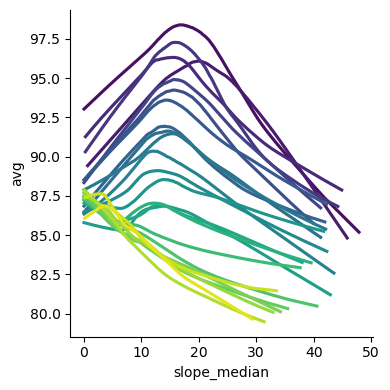

In [38]:
sns.lmplot(data = gdf_hexbin.dropna(), 
            x = 'slope_median', y = 'avg', hue ='bdensity_bin' , 
            scatter = False, lowess = True, palette = 'viridis', ci = .95, height = 4, legend = False)


In [21]:
from statsmodels.distributions.empirical_distribution import ECDF

In [60]:
dataset.groupby("Agglo_Name").size().sort_values(ascending = False).head(10).index.tolist()

['Rural',
 'Zürich',
 'Basel',
 'Genève',
 'Bern',
 'Lausanne',
 'Lugano',
 'Luzern',
 'St. Gallen',
 'Locarno']

In [90]:
ecdf_spatial_lst = []
ecdf_aspatial_lst = []
var_list = ['maxvsh_Gew1','maxvsh_Nat3','maxvsh_sky','maxvsh_Lan10']

for tgt in var_list:
    # tgt = 'maxvsh_Nat3'
    agglo = 'Rural'
    dat = dataset.query('Agglo_Name == @agglo')
    spatial_vec = dat.groupby('hexbin_id')[tgt].max()
    aspatial_vec = dat[tgt]
    # fit a cdf
    ecdf_spatial = ECDF(spatial_vec)
    ecdf_aspatial = ECDF(aspatial_vec)

    ecdf_spatial_lst.append(ecdf_spatial)
    ecdf_aspatial_lst.append(ecdf_aspatial)



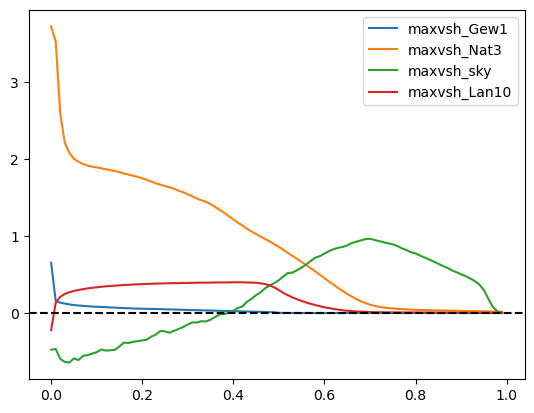

In [91]:
x_vals = np.arange(0,1,0.01)
for ecdf_spatial,ecdf_aspatial,tgt in list(zip(ecdf_spatial_lst,ecdf_aspatial_lst,var_list)):
    y_vals = np.log(ecdf_aspatial(x_vals)/ecdf_spatial(x_vals))
    plt.plot(x_vals, y_vals, label = tgt)
plt.legend()

# plt.ylim((-1,0))
# plt.yscale('log')
plt.axhline(y=0, color='k', linestyle='--')

In [92]:
ecdf_spatial_lst = []
ecdf_aspatial_lst = []
agglo_list = dataset.groupby("Agglo_Name").size().sort_values(ascending = False).head(10).index.tolist()

for agglo in agglo_list:
    tgt = 'maxvsh_Lan10'
    # agglo = 'Lausanne'
    dat = dataset.query('Agglo_Name == @agglo')
    spatial_vec = dat.groupby('hexbin_id')[tgt].max()
    aspatial_vec = dat[tgt]
    # fit a cdf
    ecdf_spatial = ECDF(spatial_vec)
    ecdf_aspatial = ECDF(aspatial_vec)

    ecdf_spatial_lst.append(ecdf_spatial)
    ecdf_aspatial_lst.append(ecdf_aspatial)



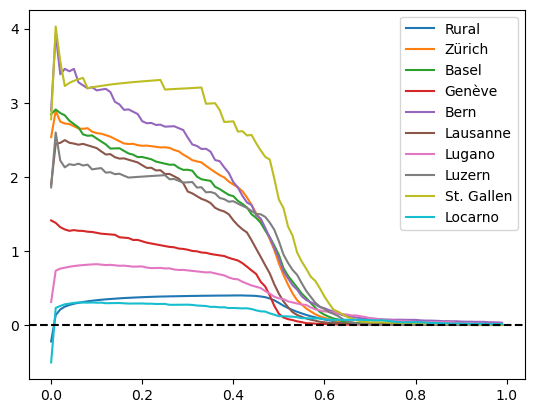

In [93]:
x_vals = np.arange(0,1,0.01)
for ecdf_spatial,ecdf_aspatial,agglo in list(zip(ecdf_spatial_lst,ecdf_aspatial_lst,agglo_list)):
    y_vals = np.log(ecdf_aspatial(x_vals)/ecdf_spatial(x_vals))
    plt.plot(x_vals, y_vals, label = agglo)
plt.legend()

# plt.ylim((-1,0))
# plt.yscale('log')
plt.axhline(y=0, color='k', linestyle='--')

In [31]:
diff_ = ecdf_aspatial.x - ecdf_spatial.x

plt.plot(diff_, ecdf_aspatial.y)

ValueError: operands could not be broadcast together with shapes (3299411,) (27050,) 

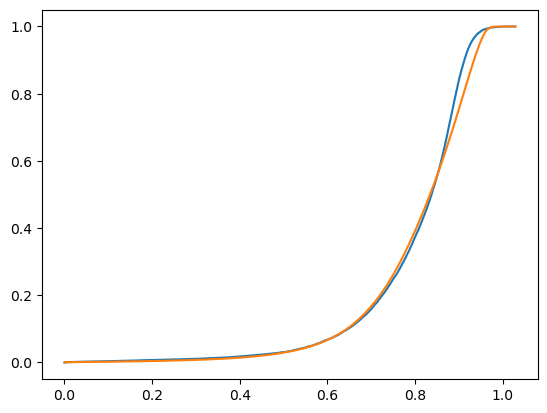

In [27]:
plt.plot(ecdf_spatial.x, ecdf_spatial.y)
plt.plot(ecdf_aspatial.x, ecdf_aspatial.y)

<Axes: xlabel='maxvsh_sky', ylabel='Proportion'>

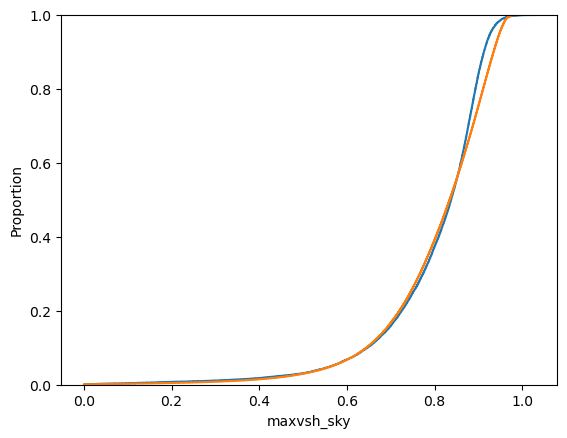

In [20]:
thres = .1
tgt = 'maxvsh_sky'
x = dataset.groupby('hexbin_id')[tgt].median()#.apply(lambda x: np.mean(x > thres))

sns.ecdfplot(x)
sns.ecdfplot(dataset[tgt])